# Interpollation (CUBIC SPLINE)

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#from last week (just for comparison)

def Newton_coeffts(xData,yData):
    m = len(xData)  # Number of data points
    a = yData.copy()
    for k in range(1,m):
        a[k:m] = (a[k:m] - a[k-1])/(xData[k:m] - xData[k-1])
    return a


def Newton_evalPoly(a,xData,x):
    n = len(xData) - 1  # Degree of polynomial
    p = a[n]
    for k in range(1,n+1):
        p = a[n-k] + (x -xData[n-k])*p
    return p

## Question 1

Given the points:

| x | y |
| --- | --- |
| 0 | 0 |
| 1 | 2 |
| 2 | 1 |

- (a) Determine the natural cubic spline that passes through the points (do it by hand)
- (b) Verify that the two cubics have the same first and second derivative at $x=1$
- (c) Implement the algorithm to compute the cubic spline given the points
- (d) Draw the cubic spline interpolation in $[0,2]$ and compare it with the interpollation obtained with newton method

Hint: There are actually two cubics:  One valid on $[0,1]$ and another one valid on $[1,2]$.

Solutions:

(a) $k_{i-1} + 4k_i + k_{i+1} = \frac{6}{h^2}(y_{i-1}-2y_i+y_{i+1}), 1\ge i \ge n-1, h=1$

$\Rightarrow$

$k_0=0$

$k_0 + 4k_1 + k_2 = 6(0-4+1) = -18$

$k_2=0$

$\Rightarrow k_1=-9/2$

$f_{i,i+1} = \frac{k_i}{6}\Big[ \frac{(x-x_{i+1})^3}{x_i-x_{i+1}} -(x-x_{i+1})(x_i-x_{i+1})\Big] - \frac{k_{i+1}}{6}\Big[\frac{(x-x_i)^3}{x_i-x_{i+1}}-(x-x_i)(x_i-x_{i+1})\Big] + \frac{y_i(x-x_{i+1})-y_{i+1}(x-x_i)}{x_i-x_{i+1}}$

$\Rightarrow$ $f_{0,1}(x) = \frac{9}{12}\Big[\frac{x^3}{-1}-(x)(-1)\Big] + \frac{0-2(x)}{-1} = \frac{-3x^3}{4} + \frac{11x}{4}$

$f_{1,2}(x) = \frac{-9}{12}\Big[\frac{(x-2)^3}{-1} + (x-2)\Big] + \frac{2(x-2)-(x-1)}{-1}=\frac{9(x-2)^3}{12}-\frac{9(x-2)}{12}-x+3$

We can check that $f_{0,1}(0)=0,f_{0,1}(1)=f_{1,2}(1)=2$ and $f_{1,2}(2)=1$ Also,

$f'_{0,1}(x) = \frac{-9x^2}{4}+\frac{11}{4}$ and $f'_{1,2}(x)=\frac{9(x-2)^2}{4}-\frac{21}{12}$

$\Rightarrow f'_{0,1}(1)=f'_{1,2}(1)=\frac{1}{2}$

Finally,

$f''_{0,1}(x)=\frac{-18x}{4}$ and $f''_{1,2}(x)=\frac{18(x-2)}{4}$

$\Rightarrow f''_{0,1}(1)=f''_{1,2}(1)=\frac{-18}{4}$

In [4]:

def cubicspline_curvatures(xData,yData):
    def LUdecomp3(c,d,e):
        n = len(d)
        for k in range(1,n):
            lam = c[k-1]/d[k-1]
            d[k] = d[k] - lam*e[k-1]
            c[k-1] = lam
        return c,d,e

    def LUsolve3(c,d,e,b):
        n = len(d)
        for k in range(1,n):
            b[k] = b[k] - c[k-1]*b[k-1]
        b[n-1] = b[n-1]/d[n-1]
        for k in range(n-2,-1,-1):
            b[k] = (b[k] - e[k]*b[k+1])/d[k]
        return b       
    
    n = len(xData) - 1
    c = np.zeros(n)
    d = np.ones(n+1)
    e = np.zeros(n)
    k = np.zeros(n+1)
    c[0:n-1] = xData[0:n-1] - xData[1:n]
    d[1:n] = 2.0*(xData[0:n-1] - xData[2:n+1])
    e[1:n] = xData[1:n] - xData[2:n+1]
    k[1:n] =6.0*(yData[0:n-1] - yData[1:n]) \
                 /(xData[0:n-1] - xData[1:n]) \
             -6.0*(yData[1:n] - yData[2:n+1])   \
                 /(xData[1:n] - xData[2:n+1])
    LUdecomp3(c,d,e)
    LUsolve3(c,d,e,k)
    return k

def cubicspline_evalSpline(xData,yData,k,x):
    
    def findSegment(xData,x):
        iLeft = 0
        iRight = len(xData)- 1
        while 1:
            if (iRight-iLeft) <= 1: return iLeft
            i = int( (iLeft + iRight)/2 )
            if x < xData[i]: iRight = i
            else: iLeft = i
    
    i = findSegment(xData,x)
    #print(i)
    h = xData[i] - xData[i+1]
    y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0 \
      - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0   \
      + (yData[i]*(x - xData[i+1])                            \
       - yData[i+1]*(x - xData[i]))/h
    return y
      

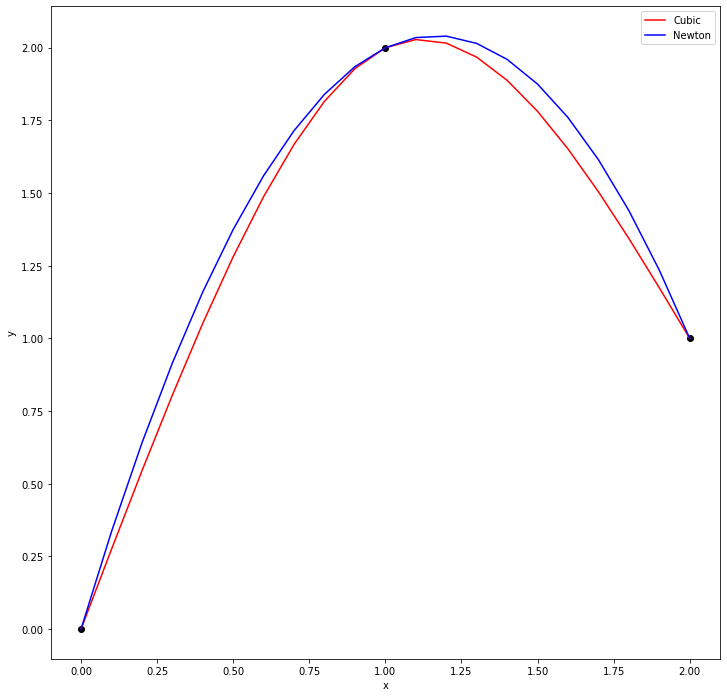

In [5]:
xData = np.array([0,1,2.0])
yData = np.array([0,2,1.0])

x = np.arange(np.min(xData), np.max(xData)+0.1, 0.1)

k = cubicspline_curvatures(xData, yData)
y_cubic   = np.array( [cubicspline_evalSpline(xData, yData, k, xi) for xi in x] )

coeffts = Newton_coeffts(xData, yData)
y_newton  = np.array( [Newton_evalPoly(coeffts, xData, xi) for xi in x] )


fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(xData, yData, 'o', color="black")
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, y_cubic , '-', color="red", label="Cubic")   
plt.plot(x, y_newton , '-', color="blue", label="Newton")   
ax.legend()



## Question 2

Using the same data as above:

| x | y |
| --- | --- |
| 0 | 0 |
| 1 | 2 |
| 2 | 1 |


Change the border condition of the cublic spline,
to impose that the first derivative is null at the first and last point instead of the standard $k_0=k_n=0$

Hint: This is similar to example 3.8 of the reference book

### Solution:

with $x_{i-1}-x_{i} = x_{i}-x_{i+1}=-h$

1) $f'_{0,1}(x_0)=0$:

$\Large f'_{0,1}(x) = \frac{k_0}{6} \left[ \frac{3(x-x_1)^2}{-h} - (-h) \right] - \frac{k_1}{6} \left[ \frac{3(x-x_0)^2}{-h} -(-h) \right] + \frac{y_0-y_1}{-h} = 0$ 

$\Large f'_{0,1}(x_0) = \frac{k_0}{6} \left[ -3(-1)^2 +1 \right] - \frac{k_1}{6} \left[ 3(0)^2 +1 \right] + 2 = 0$ 

$\Large \rightarrow -2k_0 - k_1  + 12 = 0$ 

2) $f'_{1,2}(x_2)=0$:

$\Large f'_{1,2}(x) = \frac{k_1}{6} \left[ \frac{3(x-x_2)^2}{-h} -(-h) \right] - \frac{k_2}{6} \left[ \frac{3(x-x_1)^2}{-h} -(-h) \right] + \frac{y_1-y_2}{-h} = 0$ 

$\Large f'_{1,2}(x_2) = \frac{k_1}{6} \left[ -3(0)^2 +1 \right] - \frac{k_2}{6} \left[ -3(1)^2 +1 \right] - (2-1) = 0$ 

$\Large \rightarrow k_1 + 2k_2 - 6 = 0$ 

3) We also keep the usual condition for the curvature at $k_1$:

$\Large \rightarrow k_0 + 4k_1 + k_2 = \frac{6}{h^2}(y_0-2y_1+y_2) = -18$ 


Now we should solve the system to find the values of $k_0, k_1, k_2$
We will find: 
- $k_0=10.5$
- $k_1=-9$
- $k_2=7.5$

In [4]:
def gaussEliminPP(a, b):
    n = len(b)
    # Elimination Phase
    for k in range(0, n-1): #iterate on rows
        pivot_idx = k + list(np.abs(a[k:n, k])).index(max(np.abs(a[k:n, k])))
        temp_a = a[k].copy()
        temp_b = b[k].copy()
        a[k] = a[pivot_idx]
        b[k] = b[pivot_idx]
        a[pivot_idx] = temp_a
        b[pivot_idx] = temp_b
        
        for i in range(k+1, n): 
            if a[i,k] != 0.0:
                lam = a[i, k] / a[k, k]
                a[i, k+1:n] = a[i, k+1:n] - lam*a[k, k+1:n]
                b[i] = b[i] - lam*b[k]            
        #a[k+1:,k] = 0 #optional, set element bellow pivot to 0
        
    # Back substitution
    for k in range(n-1, -1, -1):
        b[k] = (b[k] - np.dot(a[k, k+1:n], b[k+1:n])) / a[k, k]
    return b
        

A = np.array([[-2,-1,0], [1,4,1], [0,1,2]], dtype=np.float32)
display(A)

b = np.array([-12,-18,6], dtype=np.float32)
display(b)

curvatures2 = gaussEliminPP(A,b)
display(curvatures2)

array([[-2., -1.,  0.],
       [ 1.,  4.,  1.],
       [ 0.,  1.,  2.]], dtype=float32)

array([-12., -18.,   6.], dtype=float32)

array([10.5      , -9.       ,  7.5000005], dtype=float32)

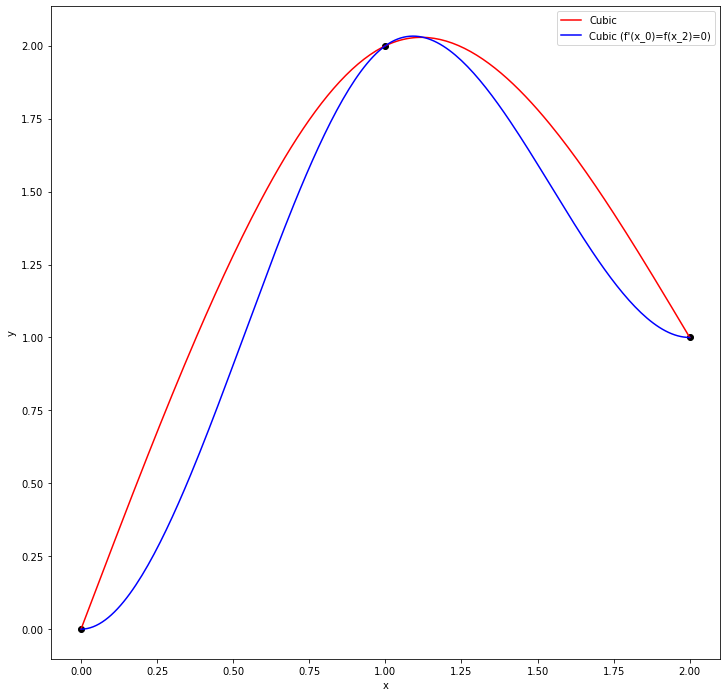

In [8]:
xData = np.array([0,1,2.0])
yData = np.array([0,2,1.0])

x = np.arange(np.min(xData), np.max(xData)+0.01, 0.01)

k = cubicspline_curvatures(xData, yData)
y_cubic   = np.array( [cubicspline_evalSpline(xData, yData, k, xi) for xi in x] )
y_cubic2  = np.array( [cubicspline_evalSpline(xData, yData, curvatures2, xi) for xi in x] )

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(xData, yData, 'o', color="black")
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, y_cubic , '-', color="red", label="Cubic")   
plt.plot(x, y_cubic2 , '-', color="blue", label="Cubic (f'(x_0)=f(x_2)=0)")   
ax.legend()

## Question 3

Given the points:

| x | f(x) |
| --- | --- |
| 0.2 | 1.150 |
| 0.4 | 0.855 |
| 0.6 | 0.377 |
| 0.8 | -0.266 |
| 1.0 | -1.049 |

Compute the zero of the function f(x) using natural cubic spline.

Hint: Reorder the points such that they are in ascending value of f(x)

Solutions:

| x | f(x) |
| --- | --- |
| 1.0 | -1.049 |
| 0.8 | -0.266 |
| 0.6 | 0.377 |
| 0.4 | 0.855 |
| 0.2 | 1.150 |

$k_0=0$

$k_0 + 4k_1 = k_2 = -21$

$k_1 + 4k_2 + k_3 = -24.75$

$k_2 + 4k_3 + k_4 = -27.45$

$k_4=0$

$\Rightarrow k_1 = -4.3473,~k_2=-3.6107,~k_3=-5.9598$

$\Rightarrow f_{1,2}(x) = \frac{k_1}{6}\Big[\frac{(x-0.6)^3}{0.2} -(x-0.6)(0.2)\Big] - \frac{k_2}{6}\Big[\frac{(x-0.8)^3}{0.2} - (x-0.8)(0.2)\Big] + \frac{-0.266(x-0.6)-0.377(x-0.8)}{0.2}$

$f_{1,2}(x)=0 \Rightarrow x \approx 0.72316$


3
-0.266
[ 0.         -5.95982143 -3.61071429 -4.34732143  0.        ]


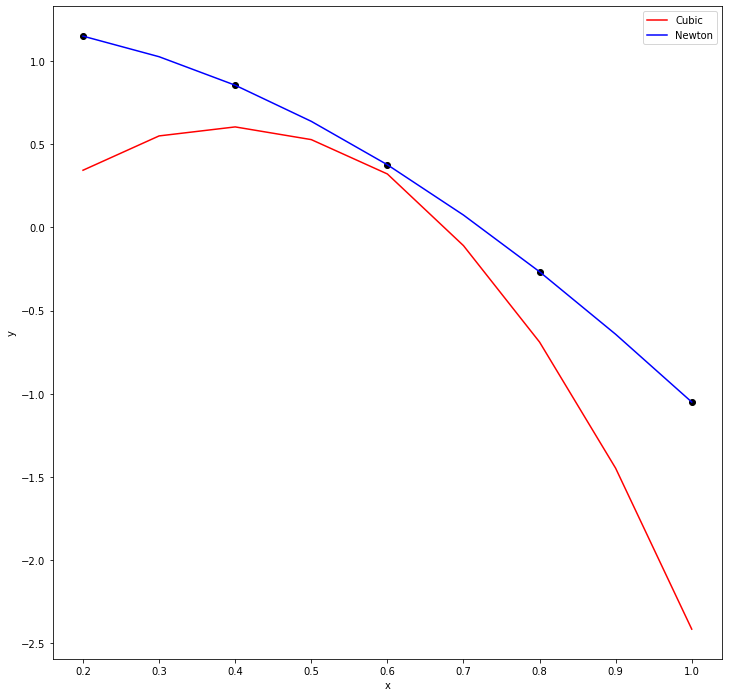

In [24]:
xData = np.array([0.2,0.4,0.6,0.8,1])
yData = np.array([1.150,0.855,0.377,-0.266,-1.049])

x = np.arange(np.min(xData), np.max(xData)+0.1, 0.01)

x = np.arange(np.min(xData), np.max(xData)+0.1, 0.1)

k = cubicspline_curvatures(xData, yData)
#y_cubic   = np.array( [cubicspline_evalSpline(xData, yData, k, xi) for xi in x] )

print(cubicspline_evalSpline(xData, yData, k, 0.8))

coeffts = Newton_coeffts(xData, yData)
y_newton  = np.array( [Newton_evalPoly(coeffts, xData, xi) for xi in x] )

print(k)
fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(xData, yData, 'o', color="black")
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, y_cubic , '-', color="red", label="Cubic")   
plt.plot(x, y_newton , '-', color="blue", label="Newton")   
ax.legend()


# Least Square Fits

## Question 4

The following table displays the mass M and average fuel consumption $\phi$ of
motor vehicles manufactured by Ford and Honda in 2008. Fit a straight line $\phi =
a + bM$ to the data and compute the standard deviation.

|Model | M (kg) | φ (km/liter)|
| --- | --- | --- |
|Focus| 1198 |11.90|
|Crown Victoria |1715 |6.80|
|Expedition |2530| 5.53|
|Explorer| 2014 |6.38|
|F-150 |2136| 5.53|
|Fusion| 1492| 8.50|
|Taurus| 1652| 7.65|
|Fit |1168 |13.60|
|Accord |1492 | 9.78|
|CR-V |1602| 8.93|
|Civic | 1192 |11.90|
|Ridgeline | 2045| 6.38|



**Solution:**

$\bar M = 1686.33$, $\bar\phi$ = 8.55$

$b = \frac{\sum \phi_i (M_i - \bar M)}{\sum M_i (M_i - \bar M)} = -0.005833$

$a = \bar \phi - \bar M b = 18.3860$

$\Longrightarrow \phi = 18.3860 - 0.005833 M$

Standard deviation: $\sigma = \sqrt{\frac{1}{11-1} \sum (\phi_{pred} - \phi_{real})^2} = 1.1644$


## Question 5

Fit a straight line and a quadratic to the data in the following table.

| x | y |
| --- | --- |
| 1.0 | 6.008 |
| 2.5 | 15.722 |
| 3.5 | 27.130 |
| 4.0 | 33.772 |
| 1.1 | 5.257 |
| 1.8 |9.549 |
| 2.2 |11.098 |
| 3.7 |28.828|

Which is a better fit?

Hint:  compute the standard deviation for both

In [1]:
import numpy as np
import math

def choleski(a):
    n = len(a)
    for k in range(n):
        try:
            a[k,k] = math.sqrt(a[k,k] - np.dot(a[k,0:k],a[k,0:k]))
        except ValueError:
            raise Exception('Matrix is not positive definite')
        for i in range(k+1,n):
            a[i,k] = (a[i,k] - np.dot(a[i,0:k],a[k,0:k]))/a[k,k]
    for k in range(1,n): a[0:k,k] = 0.0 #erase upper triangle
    return a

def choleskiSol(L,b):
    n = len(b)
  # Solution of [L]{y} = {b}  
    for k in range(n):
        b[k] = (b[k] - np.dot(L[k,0:k],b[0:k]))/L[k,k]
  # Solution of [L_transpose]{x} = {y}      
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(L[k+1:n,k],b[k+1:n]))/L[k,k]
    return b

"""
Polunomial fit implementation
"""
def polyFit(xData, yData, m):
    a = np.zeros((m+1, m+1))
    b = np.zeros(m+1)
    s = np.zeros(2*m+1)
    for i in range(len(xData)):
        temp = yData[i]
        for j in range(m+1):
            b[j] += temp
            temp *= xData[i]
        temp = 1.0
        for j in range(2*m+1):
            s[j] += temp
            temp *= xData[i]
    for i in range(m+1):
        for j in range(m+1):
            a[i, j] = s[i+j]
    return choleskiSol(choleski(a), b)


xData = np.array([1., 2.5, 3.5, 4., 1.1, 1.8, 2.2, 3.7])
yData = np.array([6.008, 15.722, 27.130, 33.772, 5.257, 9.549, 11.098, 28.828])

print("Degree 1:")
coefs = polyFit(xData, yData, 1)
print(coefs)
print("Std dev:")
yPred = coefs[0] + coefs[1] * xData
print(np.sqrt((1/len(xData)) * np.sum(np.square(yPred - yData))))
print()

print("Degree 2:")
coefs = polyFit(xData, yData, 2)
print(coefs)
print("Std dev:")
yPred = coefs[0] + coefs[1] * xData + coefs[2] * np.square(xData)
print(np.sqrt((1/len(xData)) * np.sum(np.square(yPred - yData))))
print()

Degree 1:
[-6.18989525  9.43854354]
Std dev:
1.9429832700254897

Degree 2:
[ 4.40567377 -1.06889613  2.10811822]
Std dev:
0.6426759826418788



## Question 6

Use multi-variate linear regression to determine the function f(x, y) = a + bx + cy that fits the following data:

| x | y | z |
| --- | --- | --- |
| 0 | 0 | 1.42 |
| 0 | 1 | 1.85 |
| 1 | 0 | 0.78 |
| 2 | 0 | 0.18 |
| 2 | 1 | 0.60 |
| 2 | 2 | 1.05 |

What is the standard deviation of this parametrization ?

Hint: we did a similar problem during the lecture

In [1]:

import numpy as np
import math

def choleski(a):
    n = len(a)
    for k in range(n):
        try:
            a[k,k] = math.sqrt(a[k,k] - np.dot(a[k,0:k],a[k,0:k]))
        except ValueError:
            raise Exception('Matrix is not positive definite')
        for i in range(k+1,n):
            a[i,k] = (a[i,k] - np.dot(a[i,0:k],a[k,0:k]))/a[k,k]
    for k in range(1,n): a[0:k,k] = 0.0 #erase upper triangle
    return a

def choleskiSol(L,b):
    n = len(b)
  # Solution of [L]{y} = {b}  
    for k in range(n):
        b[k] = (b[k] - np.dot(L[k,0:k],b[0:k]))/L[k,k]
  # Solution of [L_transpose]{x} = {y}      
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(L[k+1:n,k],b[k+1:n]))/L[k,k]
    return b




x = np.array([0,0,1,2,2,2], dtype=np.float32)
y = np.array([0,1,0,0,1,2], dtype=np.float32)
z = np.array([1.42,1.85,0.78,0.18,0.60,1.05], dtype=np.float32)

x = x[:,np.newaxis] #column vector
y = y[:,np.newaxis] #column vector
z = z[:,np.newaxis] #column vector


X = np.hstack([np.ones(shape=x.shape), x, y])

XTX = np.matmul( np.transpose(X), X)
XTY = np.matmul( np.transpose(X), z)

L = choleski(XTX.copy())
A = choleskiSol(L, XTY.copy())
print("Coeficients:", A)


z_OLS = np.matmul(X,A)
#print(np.hstack([z_OLS,z,z_OLS-z]))


ols = np.sum(np.square(z_OLS-z))
std = np.sqrt(ols / (x.shape[0] - A.shape[0]) )
print("STD=",std)


Coeficients: [[ 1.4132558 ]
 [-0.62139535]
 [ 0.43755814]]
STD= 0.010979181821382017
